In [3]:
import shap
import pickle
import pandas as pd, numpy as np
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import GridSearchCV

import sklearn
from sklearn_pandas import DataFrameMapper

import matplotlib.pyplot as plt

In [4]:
model = pickle.load(open('../models/finalized_model_up.sav', 'rb'))

In [5]:
clean_data = pd.read_csv('clean_data.csv', infer_datetime_format = True)

In [6]:
numerical_cols=['sub_grade_num', 'short_emp', 'emp_length_num','dti', 'payment_inc_ratio', 'delinq_2yrs', \
                'delinq_2yrs_zero', 'inq_last_6mths', 'last_delinq_none', 'last_major_derog_none', 'open_acc',\
                'pub_rec', 'pub_rec_zero','revol_util']

categorical_cols=['grade', 'home_ownership', 'purpose']

mapper = DataFrameMapper([
    ('grade',sklearn.preprocessing.LabelBinarizer()),
    ('home_ownership', sklearn.preprocessing.LabelBinarizer()),
    ('purpose', sklearn.preprocessing.LabelBinarizer()),],
df_out=True)

X1 = mapper.fit_transform(clean_data)

df = pd.concat([X1, clean_data[numerical_cols]])

X2 = np.array(clean_data[numerical_cols])


X = np.hstack((X1,X2)) #Combines X1 and X2 side by side, i.e. stacks them horizontally
y = np.array(clean_data['bad_loans'])

/Users/costefan/.pyenv/versions/anaconda3-4.3.0/envs/ucu/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=100, stratify=y)

In [8]:
model.score(X_test, y_test)

0.8111542359892215

## classical random forest feature importance

Pros:
* fast calculation
* easy to retrieve — one command <br />


Cons:
* biased approach, as it has a tendency to inflate the importance of continuous features or high-cardinality categorical variables

In [9]:
model.feature_importances_

array([1.72629180e-01, 6.46118756e-02, 0.00000000e+00, 1.01344111e-02,
       7.60698821e-02, 6.29616876e-02, 1.62250695e-02, 4.33273312e-03,
       6.12916238e-04, 7.44388207e-05, 3.78464811e-03, 2.77085355e-03,
       3.32861165e-03, 2.10121573e-03, 2.99665783e-04, 9.28441627e-04,
       2.99718737e-04, 0.00000000e+00, 8.50141815e-04, 1.95410982e-03,
       3.02793120e-02, 7.83145472e-04, 6.73321182e-05, 3.55950458e-03,
       5.03906456e-04, 3.03274407e-03, 1.18207275e-01, 2.41491806e-01,
       2.50013447e-03, 9.82281306e-05, 3.33342396e-02, 6.20632925e-04,
       2.99921302e-04, 5.13461820e-03, 1.43457641e-03, 4.81206748e-04,
       1.34201816e-01])

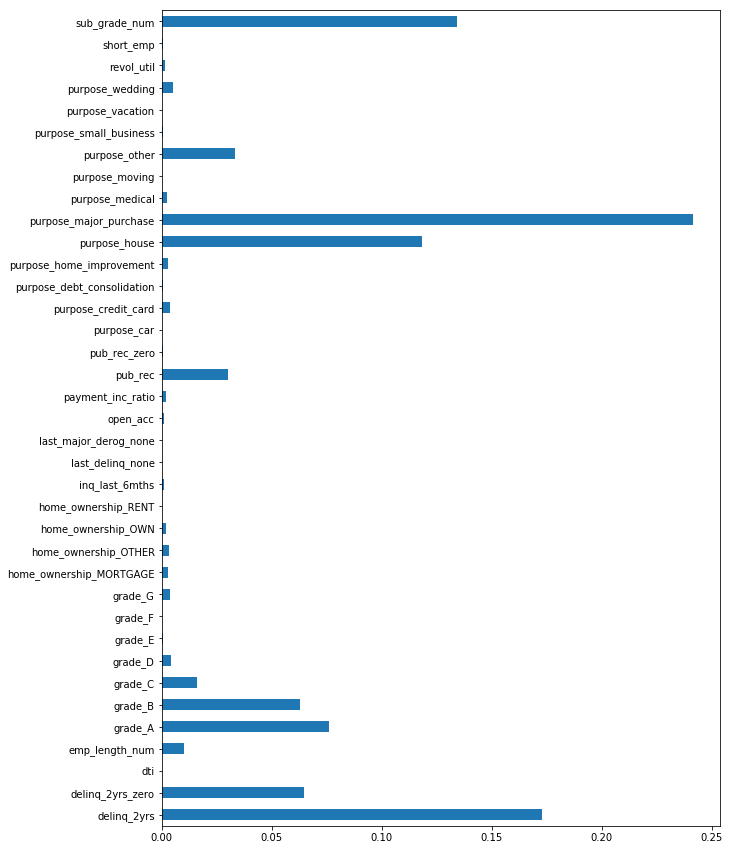

In [10]:
plt.figure(figsize=(10, 15))
pd.Series(model.feature_importances_, index=df.columns).plot(kind='barh')

## Shap tool

In [11]:
import shap

# load JS visualization code to notebook
shap.initjs()

In [12]:
subsample = X[np.random.randint(X.shape[0], size=200), :] 

In [13]:
subsample.shape

(200, 37)

In [14]:
explainer = shap.KernelExplainer(model.predict_proba, subsample)
shap_values = explainer.shap_values(subsample)

No handlers could be found for logger "shap"
  0%|          | 0/200 [00:00<?, ?it/s]/Users/costefan/.pyenv/versions/anaconda3-4.3.0/envs/ucu/lib/python2.7/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
100%|██████████| 200/200 [07:08<00:00,  2.14s/it]


            'grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies 
            'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used

In [15]:
# shap.force_plot(explainer.expected_value[0], shap_values[0], subsample, feature_names=df.columns)

## Summary plot

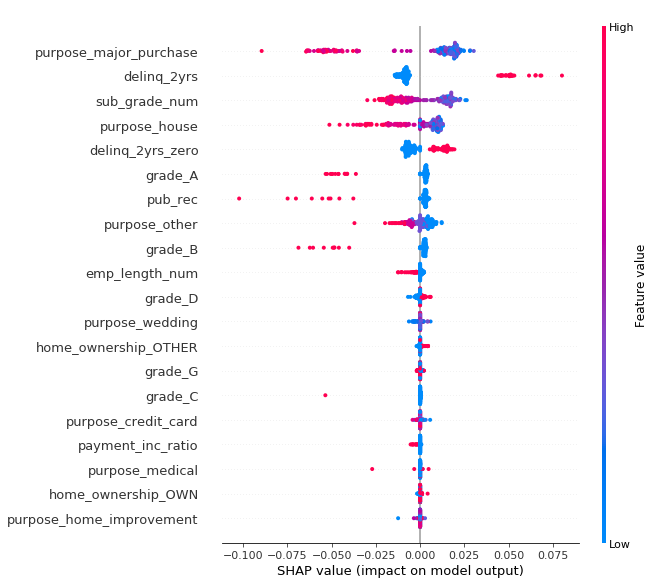

In [16]:
shap.summary_plot( shap_values[0], subsample, feature_names=df.columns)

## Dependence plot for most influential features

### delinq_2yrs - number of delinquincies

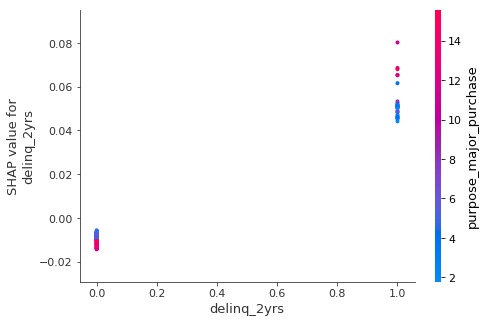

In [17]:
shap.dependence_plot('delinq_2yrs', shap_values[0], subsample, feature_names=df.columns)

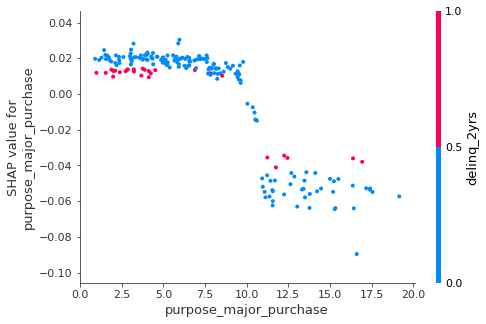

In [18]:
shap.dependence_plot('purpose_major_purchase', shap_values[0], subsample, feature_names=df.columns)

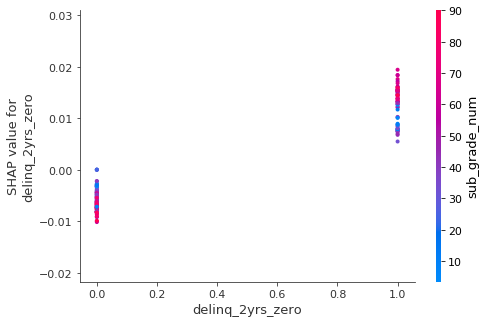

In [19]:
shap.dependence_plot('delinq_2yrs_zero', shap_values[0], subsample, feature_names=df.columns)

### emp_length_num - years of employment

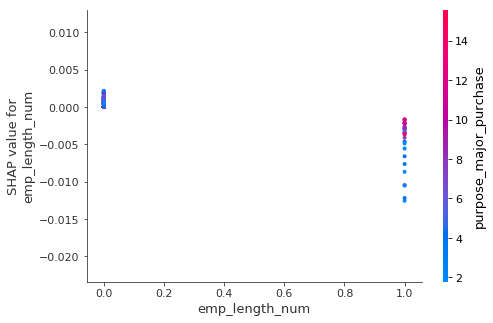

In [20]:
shap.dependence_plot('emp_length_num', shap_values[0], subsample, feature_names=df.columns)

### Force plot for single obs

In [21]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0], subsample[0], feature_names=df.columns)